In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Implementacja metody knn

In [3]:
def knn(X, y, Z, k, p=2):
    """
    X- training attributes (np.ndarray)
    y - training labels (np.ndarray one dimensional)
    Z - test attributes (np.ndarray)
    k - quantity of searched nearest neighbours (natural positive number)
    p - p-norm used in measuring distance between observations
    """
    # sprawdzenie poprawności danych wejściowych
    assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(Z, np.ndarray), 'Błędny typ danych'
    (n,r) = X.shape
    assert y.shape[0] == n, "Nieodpowiedni rozmiar y w stosunku do X"
    (m,l1) = Z.shape
    assert l1 == r, "Nieodpowiednia liczba kolumn Z w stosunku do X"
    assert p == 'infty' or p >= 1, "Nieodpowiednia wartość normy"
    assert 1 <= k and k <= n and k == np.floor(k),'Nieodpowiednia wartość k'
    
    # algorytm
    result = np.zeros(m)
    for i ,elZ in enumerate(Z):
        dist = np.zeros(n)
        for j, elX in enumerate(X):
            dist[j] = lp_distance(elZ,elX,p)
        idx_full_list = np.argsort(dist)
        idx = idx_full_list[:k]
        unique_values, counts = np.unique(y[idx], return_counts=True)
        max_count = np.max(counts)
        modes = unique_values[counts == max_count]
        result[i] = np.random.choice(modes)
    return result
        
    
    
def lp_distance(point1, point2, p=2):
    if p == 'infty':
        return np.max(np.abs(point1 - point2))

    return np.power(np.sum(np.power(np.abs(point1 - point2), p)), 1/p)

# Sprawdzenie poprawności działania
## 1. Tożsamy zbiór treningowy i testowy , 1-NN

In [ ]:
random_matrix = np.random.rand(1000, 2)
random_labels = np.random.randint(1,11,size=(1000))

In [ ]:
for p in [1,2,'infty']:
    print(f'Dla normy p={p}: ', np.all(knn(random_matrix,random_labels,random_matrix,1,p) == random_labels))

## 2. Mniejszy, prostszy zbiór danych uczących do manualnego sprawdzenia

In [ ]:
np.random.seed(311052)

In [ ]:
X = np.random.randint(-4,5,size = (10,2))

In [ ]:
Z = np.random.randint(-4,5,size = (5,2))

In [ ]:
labels_train = np.random.randint(1,3,size=(15))

In [ ]:
def plot_one_ex2(i):
    # i dopuszczalne to 0,1,2,3,4
    x_data = np.concatenate((X[:,0],Z[:,0]))
    y_data = np.concatenate((X[:,1],Z[:,1]))
    train_or_test = np.zeros(len(X) + len(Z),dtype=int)
    train_or_test[:10] = 1
    train_or_test[10+i] = -1
    data = pd.DataFrame({'X': x_data, 'Y': y_data,'target_labels':labels_train,'Z': train_or_test, 'label' : labels_train*train_or_test})
    colors = data.iloc[[0,1,2,3,4,5,6,7,8,9,10+i],4]
    custom_palette = sns.color_palette("Set1", len(set(colors)))
    sns.scatterplot(data=data.iloc[[0,1,2,3,4,5,6,7,8,9,10+i],:], x = 'X', y='Y', hue = 'label', palette=custom_palette)
    plt.grid(color='gray',linestyle='--', linewidth=0.5)

In [ ]:
plot_one_ex2(1)
plt.savefig('first.png')

In [ ]:
plot_one_ex2(2)
plt.savefig('second.png')

In [ ]:
plot_one_ex2(3)
plt.savefig('third.png')

In [ ]:
for k in [1,2,3]:
    print('Dla k=', k)
    for p in [1,2,'infty']:
        print(f'Dla p={p}: ', knn(X,labels_train[:10],Z[1:4],1,p))
    print()

# Część 3

## Zestawienie z narzędziem sci-kit

In [6]:
df = pd.read_csv('pima.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df_X = df.drop(columns=['Outcome'])
y = df.Outcome

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), df_X.columns)
    ],
    remainder='passthrough'  # Passthrough pozostałych kolumn niezmienionych
)

# Zastosowanie transformacji
normalized_data = column_transformer.fit_transform(df_X)

# Konwersja wyników z powrotem do ramki danych
X = pd.DataFrame(normalized_data, columns=df_X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=311052)


In [69]:
correct_ratios = np.zeros(25)
predictions_sklearn = np.zeros(25)
predictions_knn = np.zeros(25)
for i in range(5):
    for j in range(5):
        knn_classifier = KNeighborsClassifier(n_neighbors=2*i+1, p=j+1)
        knn_classifier.fit(X_train, y_train)
        prediction2 = knn_classifier.predict(X_test)
        predictions_sklearn[5*i+j] = np.mean(prediction2 == y_test)
        prediction1 = knn(X_train.values,y_train.values,X_test.values,i+1,j+1)
        predictions_knn[5*i+j] = np.mean(prediction1 == y_test)
        correct_ratios[5*i+j] = np.sum(prediction1 == prediction2)/len(X_test)
        print(f'neighbours: {2*i+1}; p: {j+1}',correct_ratios[i+j])

C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 1; p: 1 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 1; p: 2 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 1; p: 3 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 1; p: 4 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 1; p: 5 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 3; p: 1 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 3; p: 2 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 3; p: 3 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 3; p: 4 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 3; p: 5 0.8441558441558441


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 5; p: 1 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 5; p: 2 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 5; p: 3 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 5; p: 4 0.8441558441558441


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 5; p: 5 0.8246753246753247


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 7; p: 1 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 7; p: 2 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 7; p: 3 0.8441558441558441


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 7; p: 4 0.8246753246753247


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 7; p: 5 0.8181818181818182


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 9; p: 1 1.0


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 9; p: 2 0.8441558441558441


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 9; p: 3 0.8246753246753247


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 9; p: 4 0.8181818181818182


C:\Users\Kuba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


neighbours: 9; p: 5 0.8506493506493507


In [55]:
print(f'Średnia: {round(correct_ratios.mean(),2)},\nMediana: {round(np.median(correct_ratios),2)},\nOdchylenie standardowe: {round(np.std(correct_ratios),2)}')

Średnia: 0.91,
Mediana: 0.9,
Odchylenie standardowe: 0.05


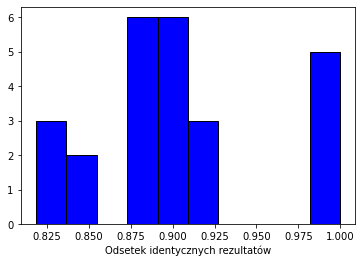

In [48]:
plt.hist(correct_ratios, bins=10, color='blue', edgecolor='black')
plt.xlabel('Odsetek identycznych rezultatów')
plt.savefig('correct_ratios1.pdf')

## Porównanie czasów wykonania

In [57]:
import time

times_sklearn = np.zeros(25)
times_knn = np.zeros(25)

for i in range(5):
    for j in range(5):
        start_time = time.time()
        knn_classifier = KNeighborsClassifier(n_neighbors=2*i+1, p=j+1)
        knn_classifier.fit(X_train, y_train)
        end_time = time.time()
        execution_time = end_time - start_time
        times_sklearn[5*i+j] = execution_time
        
        start_time = time.time()
        knn(X_train.values,y_train.values,X_test.values,i+1,j+1)
        end_time = time.time()
        execution_time = end_time - start_time
        times_sklearn[5*i+j] = execution_time

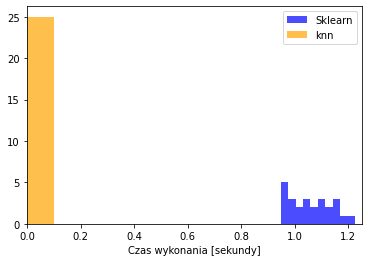

In [73]:
plt.hist(times_sklearn, bins=10, color='blue', alpha=0.7, label='Sklearn')
plt.hist(times_knn, bins=10, color='orange', alpha=0.7, label='knn')
plt.xlabel('Czas wykonania [sekundy]')
plt.legend()
plt.xlim(0,1.25)
plt.savefig('times.pdf')

## Ocena efektywności modeli

In [70]:
predictions_sklearn

array([0.68831169, 0.69480519, 0.68181818, 0.66233766, 0.65584416,
       0.7012987 , 0.72077922, 0.71428571, 0.73376623, 0.74675325,
       0.72077922, 0.72727273, 0.72727273, 0.74675325, 0.74025974,
       0.74025974, 0.75324675, 0.75974026, 0.75324675, 0.75974026,
       0.70779221, 0.73376623, 0.74025974, 0.73376623, 0.72727273])

In [71]:
predictions_knn

array([0.68831169, 0.69480519, 0.68181818, 0.66233766, 0.65584416,
       0.68831169, 0.66233766, 0.62337662, 0.67532468, 0.66883117,
       0.7012987 , 0.72077922, 0.71428571, 0.73376623, 0.74675325,
       0.72077922, 0.72077922, 0.70779221, 0.68181818, 0.71428571,
       0.72077922, 0.72727273, 0.72727273, 0.74675325, 0.74025974])

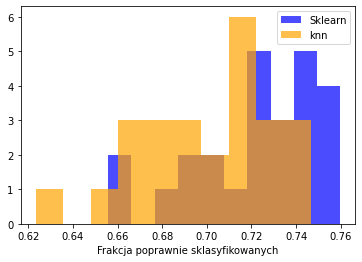

In [76]:
plt.hist(predictions_sklearn, bins=10, color='blue', alpha=0.7, label='Sklearn')
plt.hist(predictions_knn, bins=10, color='orange', alpha=0.7, label='knn')
plt.xlabel('Frakcja poprawnie sklasyfikowanych')
plt.legend()
plt.savefig('quality.pdf')

In [77]:
print(f'SKLEARN\nŚrednia: {round(predictions_sklearn.mean(),2)},\nMediana: {round(np.median(predictions_sklearn),2)},\nOdchylenie standardowe: {round(np.std(predictions_sklearn),2)}')
print(f'KNN\nŚrednia: {round(predictions_knn.mean(),2)},\nMediana: {round(np.median(predictions_knn),2)},\nOdchylenie standardowe: {round(np.std(predictions_knn),2)}')


SKLEARN
Średnia: 0.72,
Mediana: 0.73,
Odchylenie standardowe: 0.03
KNN
Średnia: 0.7,
Mediana: 0.71,
Odchylenie standardowe: 0.03
